<h3>Medium Data Exploration and NLP</h3>
<ul>
<li>Pull in data from `medium` db</li>
<li>Visualize data and missing elements</li>
<li>Perform basic NLP pipeline</li>
<li>Create a short list of features for prediction</li>
    <ul>
    <li>word count</li>
    <li>paragraph count</li>
    <li>position of highlight in document</li>
    <li>frequency/importance of highlight words</li>
    <li>sentiment of highlight words</li>
    <li>word categories (LDA, word2vec) in highlight text v. title</li>
    <li>words (LDA, word2vec) in highlight text v. article</li>
    <li>likes, number of comments, etc.</li>
    </ul>
<li>Inspect features and understand their distributions / relationships</li>
<li>Try a simple logistic regression model</li>
<li>Improve with up/down sampling?</li>
</ul>


In [136]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(dbe.url)

postgres://kimberly@localhost/medium


In [3]:
# get df 

df = pd.read_sql('articles', dbe, index_col='postid')
print(df.shape)
df.head()

(5268, 13)


,title,popdate,url,userid,username,highlight,nlikes,ncomments,ntags,origdb,tags,text,npar
postid,,,,,,,,,,,,,
1015a0f4961d,Day One: President Obama and the First Family ...,2016-03-21,https://medium.com/@ObamaWhiteHouse/day-one-pr...,ca9f8f16893b,The Obama White House,"Today, Air Force One touched down here in Hava...",336,15,3.0,3.0,"Cuba,Twitter,Cuba Trip","¡Hola desde cuba! Today, Air Force One touched...",20.0
101a407e8c61,You don’t ‘make it’ — it makes you.,2016-06-02,https://medium.com/the-mission/you-dont-make-i...,5ce28105ffbc,Jon Westenberg,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0
1030d29376f1,UX: Infinite Scrolling vs. Pagination,2016-05-02,https://uxplanet.org/ux-infinite-scrolling-vs-...,bcab753a4d4e,Nick Babich,There are only a few instances where infinite ...,1.91K,46,4.0,3.0,"UX,Design,User Experience,UX Design",“Should I use Infinite scrolling or Pagination...,34.0
10315016b299,A Lesson on Stereotypes,2016-08-20,https://medium.com/@mramsburg85/a-lesson-on-st...,d38709ba4e06,Michael Ramsburg,"Stereotypes strip you of your culture, like ou...",583,103,5.0,3.0,"Stereotypes,Appalachia,Culture,Essay,Opinion","Stereotypes./nMrs. Mitchell, my sixth grade te...",12.0
10321e751c6d,"For This Republican, Never Trump Means “I’m Wi...",2016-07-30,https://medium.com/@ccmccain/for-this-republic...,4e965facd5f9,Caroline McCain,"Trump’s statement, in my view, is unforgivable...",2.5K,302,5.0,3.0,"Hillary Clinton,Donald Trump,Never Trump,2016 ...","If you know me at all, you know I am a woman f...",45.0


In [4]:
# where is data missing?
print(df.shape)
for i in df.columns:
    print(i,df[i].count())

df_complete = df.dropna(axis=0,how='any')
print(df_complete.shape)

(5268, 13)
title 5096
popdate 5261
url 5268
userid 5263
username 5263
highlight 4764
nlikes 5262
ncomments 5262
ntags 5262
origdb 5263
tags 5262
text 5263
npar 5263
(4649, 13)


In [5]:
# dataframe of records missing any values
df_missing = df[df.isnull().any(1)]
print(df_missing.shape)
df_missing.head()

(619, 13)


,title,popdate,url,userid,username,highlight,nlikes,ncomments,ntags,origdb,tags,text,npar
postid,,,,,,,,,,,,,
10492495c715,There is something extraordinary happening in ...,2015-10-14,https://medium.com/the-global-future-of-work/t...,ff6868904c12,Gustavo Tanaka,None,7.2K,597,3.0,3.0,"Entrepreneurship,Sharing Economy,Social Media ...",Most of us haven’t quite realized there is som...,63.0
108ba9bff127,How To Make Money Selling Apps,2017-03-01,https://medium.com/appinstitute/how-to-make-mo...,6c6f187d2af6,Nabeena Mali,None,413,1,5.0,1.0,"Entrepreneurship,Franchising,Mobile App Develo...",Small businesses have — in the past — been wea...,66.0
109547bd7b2b,5 Creative Ideas For 4th Of July Social Media ...,2017-06-29,https://artplusmarketing.com/5-creative-ideas-...,3c11604f488d,Depositphotos,None,280,,5.0,1.0,"Independence Day,Marketing,Social Media Market...","By Eugine Dychko, Storyteller at Depositphotos...",16.0
10a9c0927015,Can you Code this UI Concept? Vol. 3,2016-03-08,https://stories.uplabs.com/can-you-code-this-u...,1f25a2b3cbed,Matthieu Aussaguel,None,611,9,5.0,3.0,"Design,Prototyping,Code,Material Design,UI","We’ve had fun lately at UpLabs, collecting awe...",9.0
10d41595f624,"The Sears Wish Book, 1977",2015-12-25,https://medium.com/@gregmaletic/the-sears-wish...,c30a9eb5ccc5,Greg Maletic,None,294,26,3.0,1.0,"Sears,Vintage Video Games,Mid Century",You might not recognize what this is. This is ...,40.0


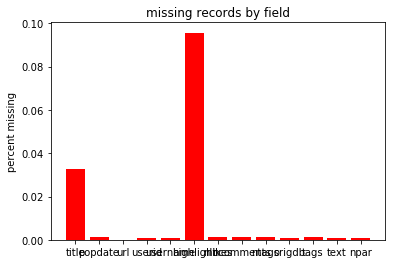

In [6]:
# how many values are missing from each column?

total_count = df.shape[0]
missing_counts = []
for i in df_missing.columns:
    mcount = df_missing[i][df_missing[i].isnull()].shape[0]
    missing_counts.append(mcount)
    
fig, ax = plt.subplots()

xtick = range(len(df_missing.columns))
mplot = [m/total_count for m in missing_counts]
rects1 = ax.bar(xtick, 
                mplot, 
                color='r')
ax.set_ylabel('percent missing')
ax.set_title('missing records by field')
ax.set_xticks(xtick)
ax.set_xticklabels(df_missing.columns)

plt.show()

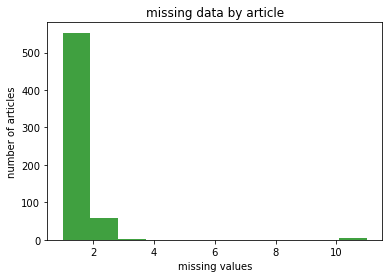

In [7]:
# how many values are missing from each entry?

m_by_article = df_missing.isnull().sum(axis=1)
m_by_article.max()

# the histogram of the data
ax = plt.hist(m_by_article, 
             m_by_article.max(), 
             facecolor='green', alpha=0.75)

plt.xlabel('missing values')
plt.ylabel('number of articles')
plt.title('missing data by article')
#labels = [item.get_text() for item in ax.get_yticklabels()]
#ax.set_xticklabels(labels)

plt.show()

In [8]:
# we will now drop all articles that are missing values...
dfC = df_complete

In [27]:
# convert nlikes and ncomments to integer
def convert_K(nstr):
    spl = nstr.split('K')
    if len(spl)==1:
        return int(float(spl[0]))
    else:
        return int(float(spl[0])*1000)
    
def convert_str(nstr):
    nstr = nstr.replace(',','')
    if nstr=='':
        return None
    else:
        return int(nstr)
        

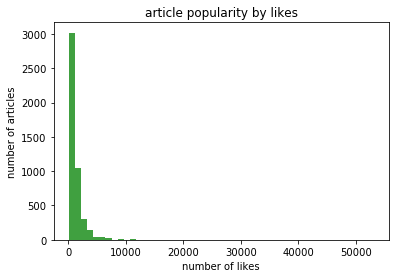

110 53000


In [33]:
# histograms of some numerical values.

nlikes = dfC.nlikes.map(convert_K)
#print(nlikes)
# the histogram of the data
n = plt.hist(nlikes, 
             50, 
             facecolor='green', alpha=0.75)

plt.xlabel('number of likes')
plt.ylabel('number of articles')
plt.title('article popularity by likes')

plt.show()

print(nlikes.min(),nlikes.max())

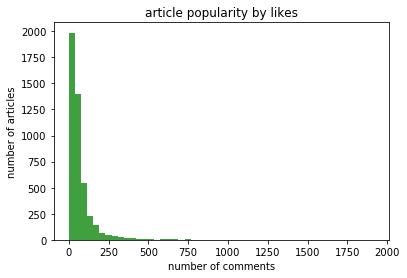

1.0 1912.0


In [35]:
# histogram of articles by comment number

ncomments = dfC.ncomments.map(convert_str)

# the histogram of the data
n = plt.hist(ncomments.dropna(), 
             50, 
             facecolor='green', alpha=0.75)

plt.xlabel('number of comments')
plt.ylabel('number of articles')
plt.title('article popularity by likes')

plt.show()

#plt.axes

print(ncomments.min(),ncomments.max())

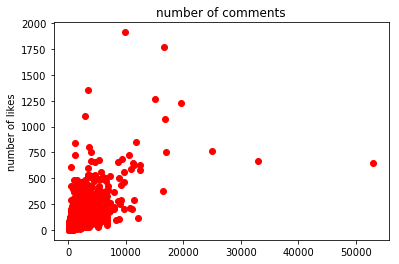

In [39]:
# are likes and comments correlated?

fig, ax = plt.subplots()
ax.scatter(nlikes, ncomments, color='r')

ax.set_ylabel('number of likes')
ax.set_title('number of comments')
#ax.set_xticks(xtick)
#ax.set_xticklabels(df_missing.columns)

plt.show()


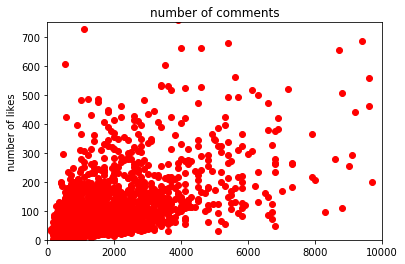

In [42]:
fig, ax = plt.subplots()
ax.scatter(nlikes, ncomments, color='r')

ax.set_ylabel('number of likes')
ax.set_title('number of comments')
#ax.set_xticks(xtick)
#ax.set_xticklabels(df_missing.columns)

plt.axis([0, 10000, 0, 750])
plt.show()

In [49]:
#dfPop = pd.concat([nlikes,ncomments])
nlikes.corr(ncomments,method='spearman')

# meh

0.57803078900326155

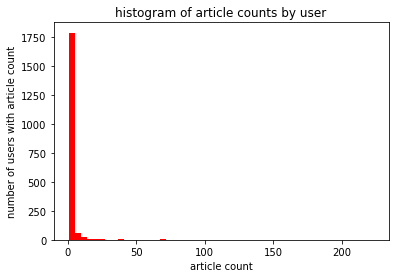

1 223


In [111]:
# visualize articles by userid

dfUser = dfC[['userid','title']].groupby('userid').count()
nUsers = dfC.userid.unique().shape[0]

fig, ax = plt.subplots()

xtick = range(nUsers)
plt.hist(dfUser.title,50,color='r')
plt.ylabel('number of users with article count')
plt.xlabel('article count')
plt.title('histogram of article counts by user')
#ax.set_xticks(xtick)
#ax.set_xticklabels(df_missing.columns)

plt.show()

print(dfUser.title.min(),dfUser.title.max())

In [67]:
dfUser.head()

,title
userid,
1001a18a1a0f,1
103a223e2d9c,1
106803413c5d,3
1082a61e84a1,1
109e4ac77b09,2


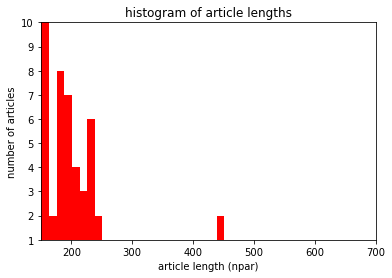

1.0 626.0


In [114]:
# histogram of article lengths

fig, ax = plt.subplots()

xtick = range(nUsers)
plt.hist(dfC.npar,50,color='r')
plt.ylabel('number of articles')
plt.xlabel('article length (npar)')
plt.title('histogram of article lengths')
#ax.set_xticks(xtick)
#ax.set_xticklabels(df_missing.columns)

plt.axis([150,700,1,10])

plt.show()

print(dfC.npar.min(),dfC.npar.max())

Looks like there are some strangely long artlces there.... Let's look at the ones over 100.

In [227]:
#dfC[((dfC.npar > 100) and (dfC.origdb==0 or dfC.origdb==4).any()).all()]

isorig04 = pd.concat([dfC.origdb==0,dfC.origdb==4],axis=1).any(axis=1)
isorig123 = pd.concat([pd.concat([dfC.origdb==1,dfC.origdb==2],axis=1).any(axis=1),dfC.origdb==3],axis=1).any(axis=1)

dfC04 = dfC[pd.concat([isorig04,dfC.npar>100],axis=1).all(axis=1)]


41

In [195]:
alist = [a for a in alist if len(a)<250]
len(alist)
#[[print(type(p)) for p in a] for a in alist]
print(nltk.word_tokenize(alist[0][4]))
tokens = [[nltk.word_tokenize(p) for p in a] for a in alist]
#print(tokens[0][0][16])
tokens = [[[t.lower() for t in p] for p in a] for a in tokens]
swords = stopwords.words('english')
nstop_tokens = [[[t for t in p if (t not in swords and t not in string.punctuation)] 
                  for p in a] for a in tokens]
#nstop_tokens = 
#tokens[0][2]
#nstop_tokens[0][2]

['In', 'the', 'end', ',', 'of', 'course', ',', 'it', 'turned', 'out', 'that', 'charging', 'people', 'money', 'for', 'a', 'product', 'they', 'enjoyed', 'wasn', '’', 't', 'a', 'terrible', 'way', 'to', 'do', 'business', '.']


In [229]:
# preprocess text
swords = stopwords.words('english')
ptext = process_text(dfC04.text,0,swords)
htext = [process_paragraph(hilite,swords) for hilite in dfC04.highlight]
ttext = [process_paragraph(title,swords) for title in dfC04.title]

In [232]:
len(ptext)
len(ptext[4])
len(ptext[4][0])
print(ptext[4][0])
print(htext[4])
print(ttext[4])

['although', 'people', 'think', 'perform', 'better', 'caffeine', 'truth', 'really', 'actually', 'become', 'dependent', 'caffeine', 'use', 'simply', 'get', 'back', 'status', 'quo', 'perform', 'become', 'incapable']
['ordinary', 'people', 'seek', 'entertainment', 'extraordinary', 'people', 'seek', 'educationand', 'learning']
['50', 'ways', 'happier', 'healthier', 'successful', 'people', 'live', 'terms']


<h3>Text Processing and Feature Extraction</h3>

<ol>
<li>Create text processing pipeline</li>
<li>Create a df of processed features for a first pass:</li>
    <ul>
    <li>word count</li>
    <li>paragraph count</li>
    <li>frequency/importance of highlight words</li>
    <li>sentiment of highlight words</li>
    <li>likes and number of comments</li>
    </ul>
<li>More features for second pass:</li>
    <ul>
    <li>position of highlight in document</li>
    <li>word categories (LDA, word2vec) in highlight text v. title</li>
    <li>words (LDA, word2vec) in highlight text v. article</li>
    </ul>
</ol>

<b>First, the text processing pipeline:</b>

In [253]:
def process_paragraph(par,swords):
    '''takes one paragraph (string); performs lower, tokenize, remove punctuation/stop words'''
    par = par.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(par)
    nstop_tokens = [t for t in tokens if (t not in swords and t not in string.punctuation)]
    return nstop_tokens                      

def process_text(atext,origdb,swords):
    '''atext is a list or series of textstrings (one from each article), 
    origdb is a list or series of corresponding original databse IDs (ints from 0-4)'''
    # initial text split
    alist = [initial_text_split(a,int(o)) for a,o in zip(atext,origdb)]
        
    # remove very long articles
    removed_articles = [aix for aix,a in enumerate(alist) if len(a)>=250]
    alist = [a for a in alist if len(a)<250]
    
    # process each paragraph
    alist = [[process_paragraph(p,swords) for p in a] for a in alist]
    
    return [alist,removed_articles]

def initial_text_split(article_text,origdb):
    '''takes article text and original db and performs appropriate splitting'''
    if origdb in [1,2,3]:
        # split into paragraphs
        plist = article_text.split('/n')

        # remove \n symbols from within words
        plist = [p.replace('\n','') for p in plist]
    
    else:
        # split into paragraphs
        plist = article_text.split('\n')
        
    return plist
    

In [254]:
# define stop word corpus and process text, highlights, and titles
swords = stopwords.words('english')

processing_output = process_text(dfC.text,dfC.origdb,swords)
ptext = processing_output[0]
removed_articles = processing_output[1]


In [261]:
# these are the articles thrown out for being too long
removed_articles

[2298, 2399, 2454, 2607, 2808, 2992, 3167, 3283, 4590]

In [262]:
# drop too-long articles
dfDrop = dfC.drop(dfC.index[removed_articles])

# process highlights and titles
htext = [process_paragraph(hilite,swords) for hilite in dfDrop.highlight]
ttext = [process_paragraph(title,swords) for title in dfDrop.title]

In [266]:
dfDrop.columns

Index(['title', 'popdate', 'url', 'userid', 'username', 'highlight', 'nlikes',
       'ncomments', 'ntags', 'origdb', 'tags', 'text', 'npar'],
      dtype='object')

<b>Now, create a dataframe of processed features:</b>

In [272]:
dfF = dfDrop.copy()

# select necessary columns
dfF = dfF[['nlikes','ncomments','popdate','npar']]

# reformat like and comment columns
dfF.nlikes = dfF.nlikes.map(convert_K)      # number of likes -> int
dfF.ncomments = dfF.ncomments.map(convert_str)  # number of comments -> int

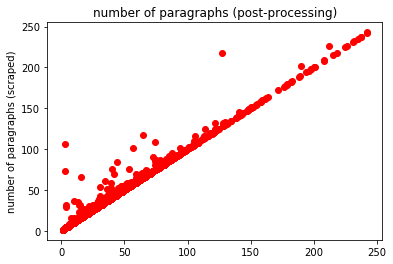

In [275]:
# are npar from scraping and npar_text correlated? (YES)

npar_text = [len(article) for article in ptext]

fig, ax = plt.subplots()
ax.scatter(dfF.npar, npar_text, color='r')

ax.set_ylabel('number of paragraphs (scraped)')
ax.set_title('number of paragraphs (post-processing)')

plt.show()

They are correlated, so we will just use the scraped value of npar already save in the df.

In [287]:
# add total word count for each article

wcount = [sum([len(par) for par in art]) for art in ptext]
dfF['wcount'] = wcount

In [288]:
dfF.head()


,nlikes,ncomments,popdate,npar,wcount
postid,,,,,
1015a0f4961d,336,15.0,2016-03-21,20.0,522
101a407e8c61,549,37.0,2016-06-02,21.0,393
1030d29376f1,1910,46.0,2016-05-02,34.0,851
10315016b299,583,103.0,2016-08-20,12.0,381
10321e751c6d,2500,302.0,2016-07-30,45.0,993
